In [1]:
import pandas as pd
import data_util
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np
from data_util import *
import threading
import multiprocessing

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import scikitplot as skplt

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras as keras
import random
from catboost import CatBoost
from sklearn.ensemble import RandomForestClassifier



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score


In [2]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np



In [3]:
path = "./data/"
trainX_raw, trainY_raw = load_data("", "train", path)
valX_raw, valY_raw = load_data("", "Val", path)

#trainX_balanced, trainY_balanced = get_balanced_set(trainX_raw, trainY_raw)

valX, valY = valX_raw, valY_raw

features = trainX_raw.shape[-1]


In [4]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=(features,))
normalizer.adapt(trainX_raw)



In [25]:
#print(Counter(trainY))


X_over, y_over = get_balanced_set(trainX_raw, trainY_raw)

print()
print("{} {}".format(Counter(y_over), Counter(trainY_raw)))

print("{} {} | {} {}".format(X_over.shape, y_over.shape, valX.shape, valY.shape))

X_train, Y_train = trainX_raw, trainY_raw

x_norm = normalizer(trainX_raw).numpy()



Counter({0: 2706, 1: 2706}) Counter({0: 2706, 1: 1858})
(5412, 26) (5412,) | (505, 26) (505,)


In [6]:
%%time
from sklearn.metrics import make_scorer, accuracy_score, f1_score


def gridSearch(x, y, clf):
    

    params = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8, 30, 100],
        'criterion' :['gini', 'entropy']
    }


    scorer = make_scorer(accuracy_score)

    clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=5)


    clf_grid.fit(x, y)
    best_param = clf_grid.best_params_
    print(best_param)
    print(clf_grid.best_score_)

    return clf_grid


CPU times: user 3.73 ms, sys: 3.32 ms, total: 7.05 ms
Wall time: 4.2 ms


In [7]:
from sklearn.metrics import classification_report, precision_score

def eval_data(model, x, y):

    #print(model.evaluate(x, y))

    pred = np.where(model.predict(x) > 0.5,1,0)

    print("Confusion Matrix {} {}".format(pred.shape, y.shape))
    print(skplt.metrics.plot_confusion_matrix(y, pred, normalize=False))
    print(precision_score(y, pred))




In [18]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.feature_selection import RFECV

train_X, train_y = x_norm, Y_train

test_X, test_y = valX, valY

feature_names = ['F{}'.format(i) for i in range(26)]


train_pool = Pool(train_X, train_y, feature_names=feature_names)
test_pool = Pool(valX, test_y, feature_names=feature_names)

model = RandomForestClassifier(verbose=False)

rfe = RFECV(model,
            #min_features_to_select = 20,
            step=1, 
            verbose=0,
            cv=5)
rfe = rfe.fit(train_X, train_y)


The mask of selected features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False  True  True  True  True
  True  True]

The feature ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1]

The external estimator: RandomForestClassifier(verbose=False)
Optimal number of features : 24


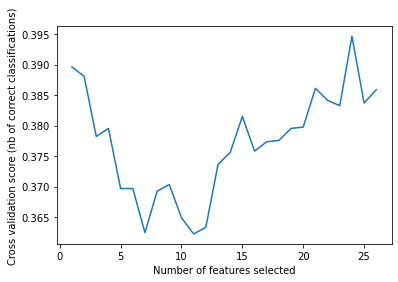

(4564, 24)


In [19]:

print('The mask of selected features: ',rfe.support_)
print()
print('The feature ranking:',rfe.ranking_)
print()
print('The external estimator:',rfe.estimator_)

print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

X_reduced = rfe.transform(X_train)

print(X_reduced.shape)

In [20]:
%%time

clf = RandomForestClassifier()

clf_grid = gridSearch(X_reduced, Y_train, clf)

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.43299009434868657
CPU times: user 25min 37s, sys: 19.2 s, total: 25min 56s
Wall time: 26min 9s


Confusion Matrix (4564,) (4564,)
AxesSubplot(0.125,0.125;0.62x0.755)
0.6415254237288136
Confusion Matrix (505,) (505,)
AxesSubplot(0.125,0.125;0.62x0.755)
0.5512820512820513


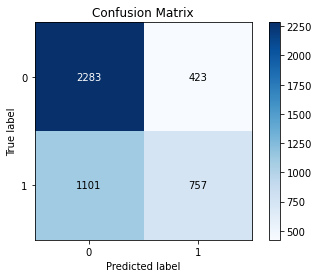

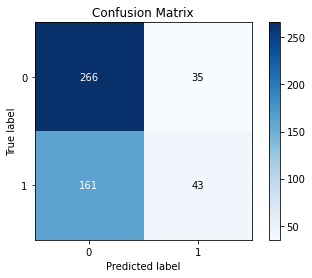

In [21]:
model = RandomForestClassifier(**clf_grid.best_params_)
model.fit(X_reduced, Y_train)

#print(model.get_best_score())
eval_data(model, X_reduced, Y_train)


#5473554735547356

Confusion Matrix (505,) (505,)
AxesSubplot(0.125,0.125;0.62x0.755)
0.5512820512820513


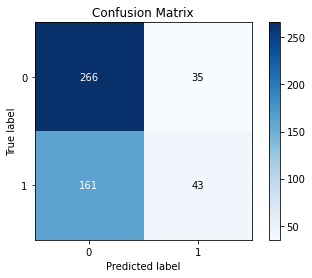

In [24]:


eval_data(model, rfe.transform(valX), valY)

